In [2]:
import provenance as p


p.load_config({'blobstores':
               {'disk': {'type': 'disk',
                         'cachedir': 'artifacts',
                         'read': True,
                         'write': True,
                         'read_through_write': False,
                         'delete': True}},
               'artifact_repos':
               {'local': {'type': 'postgres',
                          'db': 'postgresql://localhost/provenance-basic-example',
                          'store': 'disk',
                          'read': True,
                          'write': True,
                          'create_db': True,
                          'read_through_write': False,
                          'delete': True}},
               'default_repo': 'local'})

@p.provenance()
def my_add(x, y):
    print("Executed")
    return x + y

print(my_add(1, 4))

5


## Basic Example

In [3]:
import time

@p.provenance()
def expensive_add(a, b):
    time.sleep(2)
    return a + b


@p.provenance()
def expensive_mult(a, b):
    time.sleep(2)
    return a * b

In [4]:
%%time
result = expensive_add(4, 50)

CPU times: user 3.33 ms, sys: 1.71 ms, total: 5.05 ms
Wall time: 8.95 ms


In [5]:
%%time
result = expensive_add(4, 50)

CPU times: user 4.6 ms, sys: 1.84 ms, total: 6.44 ms
Wall time: 5.97 ms


In [6]:
result

<provenance.ArtifactProxy(a56451b0c65f128da0386561d7597228) 54 >

In [7]:
result.artifact.run_info

{'id': 'a9fe1ddfe8474def12482a68731f53a2',
 'host': {'system': 'Darwin',
  'machine': 'x86_64',
  'release': '18.7.0',
  'version': 'Darwin Kernel Version 18.7.0: Mon Feb 10 21:08:45 PST 2020; root:xnu-4903.278.28~1/RELEASE_X86_64',
  'nodename': 'cisl-sublimity',
  'platform': 'macOS-10.14.6-x86_64-i386-64bit',
  'cpu_count': 8,
  'processor': 'i386'},
 'process': {'cwd': '/Users/abanihi/devel/personal/brouillons-quotidien/historique',
  'exe': '/Users/abanihi/opt/miniconda3/envs/sandbox/bin/python3.8',
  'name': 'python3.8',
  'cmdline': ['/Users/abanihi/opt/miniconda3/envs/sandbox/bin/python',
   '-m',
   'ipykernel_launcher',
   '-f',
   '/Users/abanihi/Library/Jupyter/runtime/kernel-fbfe8166-456b-4ed6-8efb-09c5326c992c.json'],
  'num_fds': 62,
  'num_threads': 11},
 'created_at': datetime.datetime(2020, 5, 22, 5, 4, 13, 18987)}

In [7]:
import provenance.vis as pvis

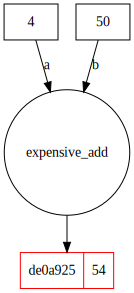

In [8]:
pvis.visualize_lineage(result)

In [9]:
import xarray as xr 

In [10]:
ds = xr.tutorial.open_dataset('rasm')
ds

<xarray.Dataset>
Dimensions:  (time: 36, x: 275, y: 205)
Coordinates:
  * time     (time) object 1980-09-16 12:00:00 ... 1983-08-17 00:00:00
    xc       (y, x) float64 ...
    yc       (y, x) float64 ...
Dimensions without coordinates: x, y
Data variables:
    Tair     (time, y, x) float64 ...
Attributes:
    title:                     /workspace/jhamman/processed/R1002RBRxaaa01a/l...
    institution:               U.W.
    source:                    RACM R1002RBRxaaa01a
    output_frequency:          daily
    output_mode:               averaged
    convention:                CF-1.4
    references:                Based on the initial model of Liang et al., 19...
    comment:                   Output from the Variable Infiltration Capacity...
    nco_openmp_thread_number:  1
    NCO:                       "4.6.0"
    history:                   Tue Dec 27 14:15:22 2016: ncatted -a dimension...

In [30]:
@p.provenance
def anomaly(ds, groupby='time.year'):
    group = ds.groupby(groupby)
    clim = group.mean()
    return ds - clim

In [31]:
%%time
anom = anomaly(ds.Tair)
anom

AttributeError: cannot set attribute '_provenance_metadata' on a 'DataArray' object. Use __setitem__ styleassignment (e.g., `ds['name'] = ...`) instead of assigning variables.

In [13]:
import numpy as np
import pandas as pd
import time
from sklearn.utils import check_random_state
import toolz as t

In [14]:
@p.provenance
def load_data(query):
    # fetch something from the DB in real life...
    random_state = check_random_state(abs(hash(query)) // (10**10))
    return random_state.uniform(0, 10, 10)


In [15]:
@p.provenance
def extract_features_a(data, hyperparam_a=5):
    time.sleep(2)
    rs = check_random_state(hyperparam_a)
    return data[0:5] + 1 + rs.rand(5)


In [16]:
@p.provenance()
def load_data(query):
    # fetch something from the DB in real life...
    random_state = check_random_state(abs(hash(query)) // (10**10))
    return random_state.uniform(0, 10, 10)


@p.provenance()
def extract_features_a(data, hyperparam_a=5):
    time.sleep(2)
    rs = check_random_state(hyperparam_a)
    return data[0:5] + 1 + rs.rand(5)


@p.provenance()
def extract_features_b(data, hyperparam_x=10):
    time.sleep(2)
    rs = check_random_state(hyperparam_x)
    return data[5:] + 1 + rs.rand(5)


@p.provenance()
def build_model(features_a, features_b, num_trees=100):
    return {'whatever': 'special model with {} trees'.format(num_trees)}


@p.provenance()
def evaluate(model, data):
    return {'some_metric': 0.5, 'another_metric': 0.4}


def pipeline(train_query='some query', valid_query="another query", hyperparam_a=5, hyperparam_x=10):
    data = load_data("some query")
    features_a = extract_features_a(data, hyperparam_a)
    features_b = extract_features_b(data, hyperparam_x)
    model = build_model(data, features_a, features_b)

    validation_data = load_data("another query")
    evaluation = evaluate(model, validation_data)

    return {'features_a': features_a, 'features_b': features_b,
            'model': model, 'evaluation': evaluation}


@p.provenance()
def make_decision(model, request):
    # make some sort of prediction, classification, with the model
    # to help make a 'decision' and return it as the result
    return {'prediction': 0.5, 'model': model.artifact.id}

In [17]:
def run_production_pipeline():
    with p.capture_set('production'):
        return pipeline()

In [18]:
res = run_production_pipeline()

In [19]:
res = p.load_set_by_name('production')

In [20]:
res

ArtifactSet(id='aba6ca7c03863c3be02247b7040fd350', artifact_ids=frozenset({'5fb1d4f00fd88dcb207c264a11f987b0', 'cad2eb7dec8c0589186b2312bc231a0a', 'e6297d97c2087f841709266e0d9804f3', '662bdf941165e1977da5481359a5ee26', '088a88ad7ec6a4fef5ee698493876985', 'b0b1af5929fc98f235eafbff0648b58e'}), created_at=datetime.datetime(2020, 5, 22, 7, 22, 54, 888784), labels={'name': 'production'})

In [21]:
data = load_data("some query")

In [22]:
data

<provenance.ArtifactProxy(e6297d97c2087f841709266e0d9804f3) array([1.62814315, 5.33644596, 2.87524842, 6.13147961, 1.43413248,
       5.48433383, 1.33431597, 4.62099253, 9.7118973 , 7.01740949]) >

In [23]:
@p.provenance()
def append_3_inc(a):
    a.append(3)
    return [n + 1 for n in a]

In [24]:
x = append_3_inc([1, 2])

ImpureFunctionError: The __main__.append_3_inc function modified arguments: (a)

In [ ]:
@p.provenance()
def load_data_y():
    return [1, 2, 3]

@p.provenance()
def process_data_y(data):
    return list(map(lambda x: x + 1, data))

data = load_data_y()

In [ ]:
data

In [ ]:
result = expensive_add(4, 50)

In [ ]:
result

In [ ]:
@p.provenance()
def load_data_y(x, y):
    return [1, 2, 3] * 2

In [ ]:
data = load_data_y(6, 3)

In [ ]:
data

In [ ]:
@p.provenance()
def load_data(x, y):
    return [x + y, x, y]

In [ ]:
load_data(3, 4)

In [ ]:
@p.provenance(name='read_only_test')
def increase(x):
    return x + 1

a = increase(5)
assert a == 6

@p.provenance(name='read_only_test', read_only=True)
def load_increase(x):
    pass

# We expect the values to be the same, and artifacts to be different
b = load_increase(5)
assert b == 6
assert b.artifact.id == a.artifact.id

not_found = load_increase(34)

In [ ]:
not_found == None

In [ ]:
not_found

In [ ]:
not_found.artifact.value is None

In [ ]:
import pandas as pd

In [25]:
@p.provenance()
def make_df(rows):
    return pd.DataFrame(rows)
    
df = make_df([{'foo': 42}, {'foo': 100}])

TypeError: save_global() missing 1 required positional argument: 'obj'

In [ ]:
df